# Objective

Implementing unsupervised learning
techniques. I have consulted a running footwear & apparel company on
strategic decisions regarding their running product & marketing. I will be using k-means clustering to
identify if there exist key running consumers using data from a recent survey to base my
recommendations on.

# Team Members

Individual Submission

# Data Preparation

In [3]:
#Import all the necessary packages

import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

#to scale the data using z-score
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#importing clustering algorithms
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

#Silhouette score
from sklearn.metrics import silhouette_score, pairwise_distances
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

In [4]:
from google.colab import files
data = files.upload()

Saving survey_data.xlsx to survey_data.xlsx


In [41]:
data=pd.read_excel('survey_data.xlsx')
data.head()

,record,id,S1r1,S1r2,S1r3,S2r1,S2r2,S3r1,S3r2,S4r1,...,Q6r1,Q6r2,Q6r3,Q6r4,Q6r5,Q7r1,Q7r2,Q7r3,Q7r4,Q7r5
0,1,9731743,1,0,0,1,0,1,0,0,...,0,1,0,1,0,0,0,1,1,0
1,2,5917428,0,0,1,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
2,3,2459391,0,0,1,1,0,0,1,0,...,0,0,0,0,1,0,1,1,0,0
3,4,3277896,0,0,1,1,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
4,5,4986375,1,0,0,1,0,0,1,1,...,0,0,0,0,1,1,0,0,0,0


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 47 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   record  175 non-null    int64
 1   id      175 non-null    int64
 2   S1r1    175 non-null    int64
 3   S1r2    175 non-null    int64
 4   S1r3    175 non-null    int64
 5   S2r1    175 non-null    int64
 6   S2r2    175 non-null    int64
 7   S3r1    175 non-null    int64
 8   S3r2    175 non-null    int64
 9   S4r1    175 non-null    int64
 10  S4r2    175 non-null    int64
 11  S4r3    175 non-null    int64
 12  S4r4    175 non-null    int64
 13  S4r5    175 non-null    int64
 14  S4r6    175 non-null    int64
 15  Q1r1    175 non-null    int64
 16  Q1r2    175 non-null    int64
 17  Q1r3    175 non-null    int64
 18  Q2r1    175 non-null    int64
 19  Q2r2    175 non-null    int64
 20  Q2r3    175 non-null    int64
 21  Q2r4    175 non-null    int64
 22  Q3r1    175 non-null    int64
 23  Q3r2    175 non

Observations:

There are 175 observations and 10 columns in the data.
All columns have 175 non-null values i.e. there are no missing values.
All the columns are numerical.
Everything looks great, lets move ahead to check duplicates.

In [43]:
data[data.duplicated()]

,record,id,S1r1,S1r2,S1r3,S2r1,S2r2,S3r1,S3r2,S4r1,...,Q6r1,Q6r2,Q6r3,Q6r4,Q6r5,Q7r1,Q7r2,Q7r3,Q7r4,Q7r5


There are no duplicate rows in the data

In [44]:
data.drop(['record', 'id'], axis=1, inplace=True)

Dropping 'record' and 'id' columns as they're identifiers

In [45]:
#Creating copy of the data to store labels from each algorithm
data_copy = data.copy()

# Similarity Metric & Matrix

To select a suitable similarity metric , we can consider using Jaccard similarity, which is often employed for binary data, as it calculates similarity between sets by comparing their intersection and union.

Jaccard similarity between two sets A and B is computed as the ratio of the size of the intersection of A and B to the size of their union:

Jaccard similarity(A,B)= ∣A∩B∣ / ∣A∪B∣

This metric is particularly useful when dealing with categorical features with binary values (0 or 1). It measures the proportion of common "1" values among the two sets of binary features.



In [26]:
# Converting the data to NumPy array
survey_array = data.values

# Calculating Jaccard similarity
jaccard_similarity = pairwise_distances(survey_array.T, metric='jaccard')

print(jaccard_similarity)

[[0.         0.9924812  1.         ... 0.83870968 0.83185841 0.83783784]
 [0.9924812  0.         1.         ... 0.83870968 0.88888889 0.94444444]
 [1.         1.         0.         ... 0.83050847 0.96363636 0.89795918]
 ...
 [0.83870968 0.83870968 0.83050847 ... 0.         0.93939394 1.        ]
 [0.83185841 0.88888889 0.96363636 ... 0.93939394 0.         0.9       ]
 [0.83783784 0.94444444 0.89795918 ... 1.         0.9        0.        ]]


# Clustering Algorithm

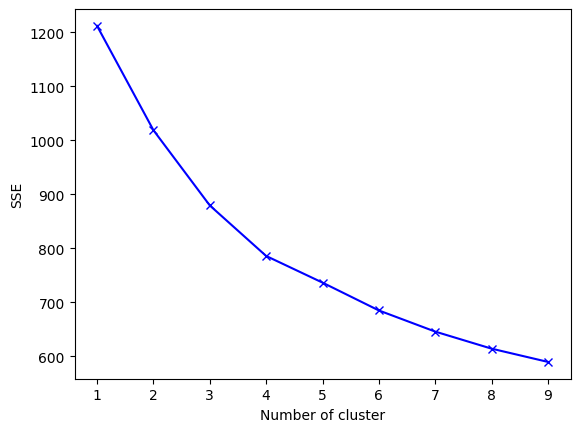

In [27]:
#Empty dictionary to store the SSE for each value of k
sse = {}

# iterate for a range of Ks and fit the scaled data to the algorithm. Use inertia attribute from the clustering object and
# store the inertia value for that k
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(data)
    sse[k] = kmeans.inertia_

#Elbow plot
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

The elbow plot does not provide any clear picture of the number of clusters. Checking the Silhouette score

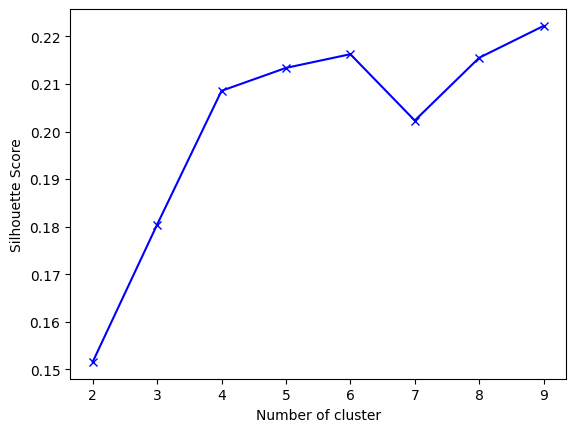

In [28]:
#Empty dictionary to store the Silhouette score for each value of k
sc = {}

# iterate for a range of Ks and fit the scaled data to the algorithm. Store the Silhouette score for that k
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(data)
    labels = kmeans.predict(data)
    sc[k] = silhouette_score(data, labels)

#Elbow plot
plt.figure()
plt.plot(list(sc.keys()), list(sc.values()), 'bx-')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")
plt.show()

Here the score is Highest for number of clusters = 6. But 4 and 5 to have similar scores. So we wil consider 4 and 6 and evaluate. Later we will evaluate for number clusters from 3 to 6

## For number of clusters = 4

In [39]:
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(data)

#Adding predicted labels to the original data and scaled data
data_copy['KMeans_Labels'] = kmeans.predict(data)
data['KMeans_Labels'] = kmeans.predict(data)

In [40]:
data['KMeans_Labels'].value_counts()

1    57
2    51
3    50
0    17
Name: KMeans_Labels, dtype: int64

In [31]:
#Calculating mean and median of the original data for each label
mean = data.groupby('KMeans_Labels').mean()
median = data.groupby('KMeans_Labels').median()
df_kmeans = pd.concat([mean, median], axis=0)
df_kmeans.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_3 Mean','group_0 Median', 'group_1 Median', 'group_2 Median', 'group_3 Median']
df_kmeans.T

,group_0 Mean,group_1 Mean,group_2 Mean,group_3 Mean,group_0 Median,group_1 Median,group_2 Median,group_3 Median
S1r1,0.74,0.634615,0.595745,0.192308,1.0,1.0,1.0,0.0
S1r2,0.14,0.192308,0.170213,0.230769,0.0,0.0,0.0,0.0
S1r3,0.12,0.173077,0.234043,0.076923,0.0,0.0,0.0,0.0
S2r1,1.00,1.000000,1.000000,0.076923,1.0,1.0,1.0,0.0
S2r2,0.00,0.000000,0.000000,1.000000,0.0,0.0,0.0,1.0
S3r1,0.52,0.442308,0.510638,0.038462,1.0,0.0,1.0,0.0
S3r2,0.48,0.557692,0.489362,0.115385,0.0,1.0,0.0,0.0
S4r1,0.66,0.000000,0.000000,0.153846,1.0,0.0,0.0,0.0
S4r2,0.26,0.096154,0.085106,0.115385,0.0,0.0,0.0,0.0
S4r3,0.00,0.096154,0.680851,0.076923,0.0,0.0,1.0,0.0


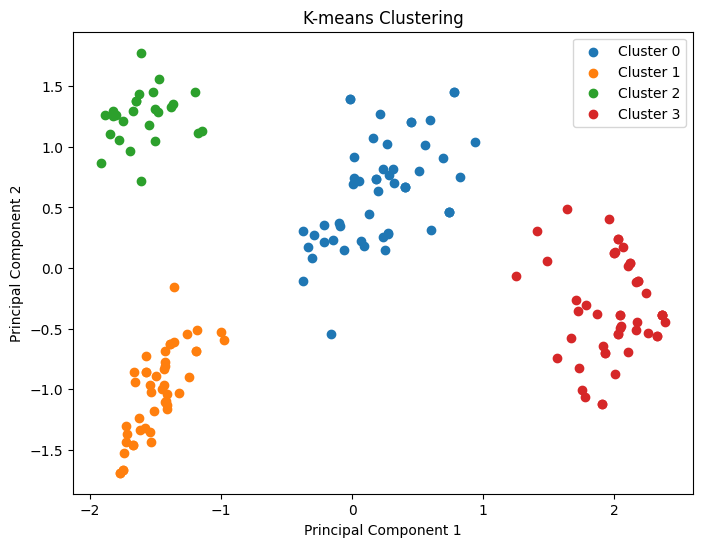

In [32]:
# Use PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

# Fit K-means on reduced data
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(data_pca)

# Add predicted labels to the PCA-reduced data
data_pca_with_labels = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
data_pca_with_labels['KMeans_Labels'] = kmeans.labels_

# Plot clusters in a 2D scatter plot
plt.figure(figsize=(8, 6))
for label in range(4):
    plt.scatter(data_pca_with_labels[data_pca_with_labels['KMeans_Labels'] == label]['PC1'],
                data_pca_with_labels[data_pca_with_labels['KMeans_Labels'] == label]['PC2'],
                label=f'Cluster {label}')

plt.title('K-means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

## For number of clusters = 6

In [33]:
kmeans = KMeans(n_clusters=6, random_state=1)
kmeans.fit(data)

#Adding predicted labels to the original data and scaled data
data_copy['KMeans_Labels'] = kmeans.predict(data)
data['KMeans_Labels'] = kmeans.predict(data)

In [34]:
data['KMeans_Labels'].value_counts()

5    50
0    31
1    29
2    26
3    22
4    17
Name: KMeans_Labels, dtype: int64

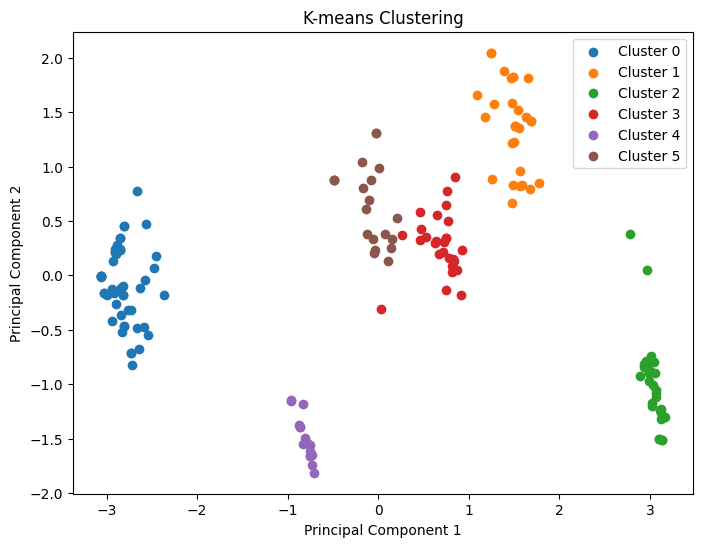

In [35]:
# Use PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

# Fit K-means on reduced data
kmeans = KMeans(n_clusters=6, random_state=1)
kmeans.fit(data_pca)

# Add predicted labels to the PCA-reduced data
data_pca_with_labels = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
data_pca_with_labels['KMeans_Labels'] = kmeans.labels_

# Plot clusters in a 2D scatter plot
plt.figure(figsize=(8, 6))
for label in range(6):
    plt.scatter(data_pca_with_labels[data_pca_with_labels['KMeans_Labels'] == label]['PC1'],
                data_pca_with_labels[data_pca_with_labels['KMeans_Labels'] == label]['PC2'],
                label=f'Cluster {label}')

plt.title('K-means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Results

In [46]:
# Dictionary to store value counts for each number of clusters
value_counts_dict = {}

# Iterate through different numbers of clusters
for num_clusters in range(3, 7):
    # Fit K-means for the current number of clusters
    kmeans = KMeans(n_clusters=num_clusters, random_state=1)
    kmeans.fit(data)

    # Assign labels to original data
    data[f'KMeans_Labels_{num_clusters}'] = kmeans.labels_

    # Get value counts for the current number of clusters
    value_counts = data[f'KMeans_Labels_{num_clusters}'].value_counts()
    value_counts_dict[num_clusters] = value_counts

# Convert the dictionary of value counts to a DataFrame
value_counts_df = pd.DataFrame(value_counts_dict)
value_counts_df

,3,4,5,6
0,78.0,50.0,50.0,17
1,47.0,52.0,30.0,50
2,50.0,47.0,52.0,30
3,NaN,26.0,26.0,23
4,NaN,NaN,17.0,26
5,NaN,NaN,NaN,29


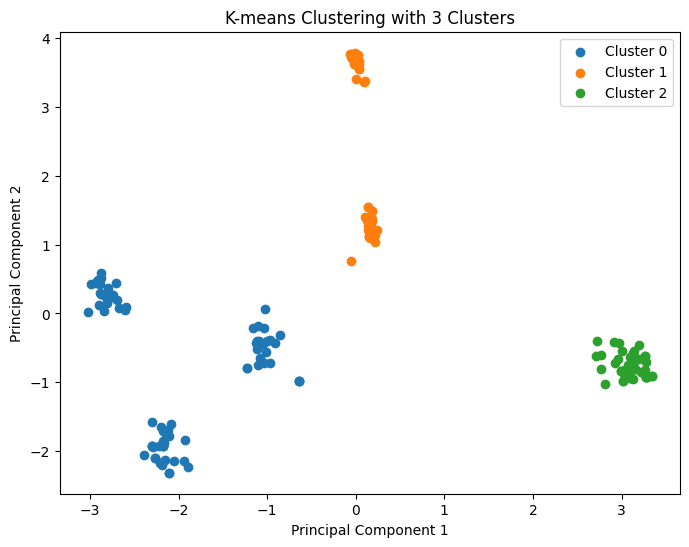

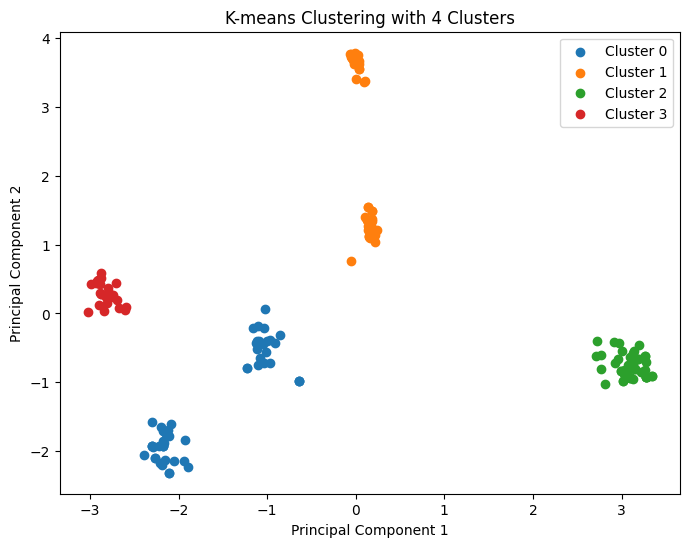

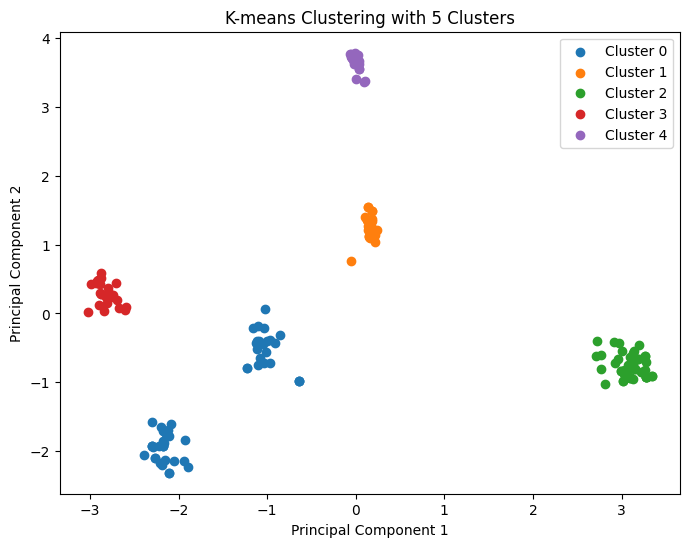

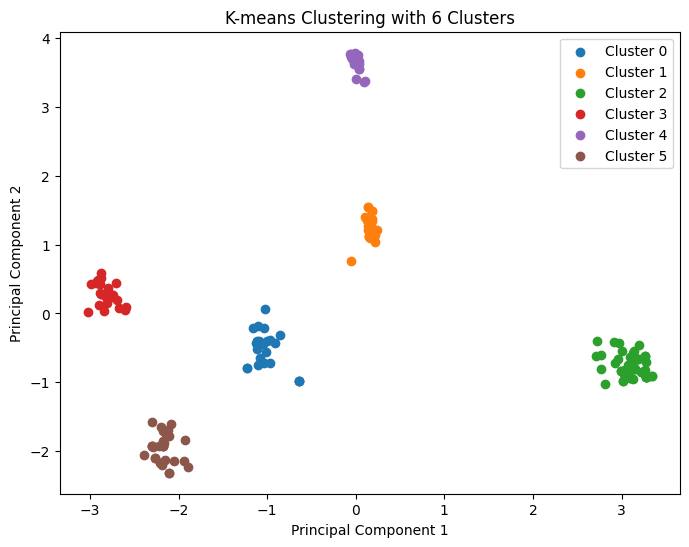

In [47]:
# Use PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

# Iterate through different numbers of clusters
for num_clusters in range(3, 7):
    # Fit K-means on the original data
    kmeans = KMeans(n_clusters=num_clusters, random_state=1)
    kmeans.fit(data)

    # Add predicted labels to the original data
    data[f'KMeans_Labels_{num_clusters}'] = kmeans.labels_

    # Fit K-means on reduced data
    kmeans_pca = KMeans(n_clusters=num_clusters, random_state=1)
    kmeans_pca.fit(data_pca)

    # Add predicted labels to the PCA-reduced data
    data_pca_with_labels = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
    data_pca_with_labels[f'KMeans_Labels_{num_clusters}'] = kmeans_pca.labels_

    # Plot clusters in a 2D scatter plot
    plt.figure(figsize=(8, 6))
    for label in range(num_clusters):
        plt.scatter(data_pca_with_labels[data_pca_with_labels[f'KMeans_Labels_{num_clusters}'] == label]['PC1'],
                    data_pca_with_labels[data_pca_with_labels[f'KMeans_Labels_{num_clusters}'] == label]['PC2'],
                    label=f'Cluster {label}')

    plt.title(f'K-means Clustering with {num_clusters} Clusters')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()


The analysis of the dataset using K-means clustering for various numbers of clusters, ranging from 3 to 6, indicates a significant distinction observed particularly when the algorithm is set to form six clusters. Both the visual representation in the scatter plots and the value counts table emphasize the distinct grouping achieved when the number of clusters is set to 6.

The scatter plots depicting the data in two dimensions showcase a clear separation into six distinguishable clusters. Each cluster appears to encapsulate a unique grouping pattern, illustrating well-defined boundaries between clusters. Moreover, examining the value counts for each cluster label further solidifies the observation. With six clusters, the data gets divided into distinct groups, each having a substantial number of observations.

***Cluster Characteristics:***

**Clusters 0, 1, and 2:** These clusters, having larger values in the counts, likely represent dominant consumer groups with certain common behaviors or preferences.

**Clusters 3, 4, and 5:** These clusters have relatively smaller counts, suggesting specific, perhaps niche, consumer segments within the dataset.

***Recommendations:***

**Product Portfolio**: Tailoring products according to the preferences and needs specific to each cluster could enhance the product portfolio. For instance, if Cluster 3 mostly prefers a certain type of shoe cushioning or color, the company might consider designing products that specifically cater to this preference.

**Marketing Strategies:** Targeted marketing campaigns can be crafted based on each cluster's characteristics. For instance, if Cluster 2 consists of consumers who prefer certain physical activities outside of running, marketing campaigns could focus on promoting shoes suitable for those activities.

**Personalization:** By understanding each cluster's distinct preferences, the company could personalize its approach to engage with key consumers more effectively. This could involve targeted advertising, customized product recommendations, or loyalty programs tailored to suit each cluster's preferences.
